In [158]:
%matplotlib inline
import matplotlib.pyplot as plt

In [159]:
import numpy as np
import pandas as pd
import datetime as dt

In [160]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [161]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [162]:
# Reflect an existing database into a new model
Base = automap_base()

In [163]:
# Reflect the tables
Base.prepare(engine, reflect=True)

In [164]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [165]:
# Create a session (link) from Python to the DB
session = Session(engine)

In [166]:
# Precipitation Analysis
# Find the most recent date in the dataset
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d')

In [167]:
# Calculate the date 1 year ago from the last data point in the database
one_year_ago = most_recent_date - dt.timedelta(days=365)

In [168]:
# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()

In [169]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])
precipitation_df.set_index('Date', inplace=True)

In [170]:
# Sort the dataframe by date
precipitation_df = precipitation_df.sort_index()

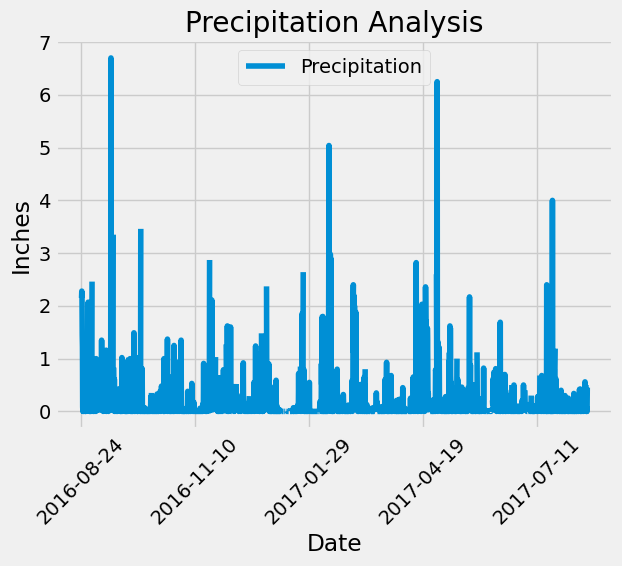

In [171]:
# Plot the results
precipitation_df.plot(rot=45)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title("Precipitation Analysis")
plt.show()

In [172]:
# Use Pandas to print the summary statistics for the precipitation data
print(precipitation_df.describe())

       Precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


In [173]:
# Station Analysis
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station.station).count()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [174]:
# Design a query to find the most active stations
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

In [175]:
most_active_station = most_active_stations[0][0]
print(f"The most active station is {most_active_station} with {most_active_stations[0][1]} observations.")

The most active station is USC00519281 with 2772 observations.


In [176]:
# Design a query to calculate the lowest, highest, and average temperatures for the most active station
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

In [177]:
print(f"Temperature Stats for Station {most_active_station}:")
print(f"Lowest Temperature: {temperature_stats[0][0]}")
print(f"Highest Temperature: {temperature_stats[0][1]}")
print(f"Average Temperature: {temperature_stats[0][2]}")

Temperature Stats for Station USC00519281:
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


In [178]:
# Design a query to get the previous 12 months of temperature observation (TOBS) data for the most active station
tobs_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()

In [179]:
# Save the query results as a Pandas DataFrame
tobs_df = pd.DataFrame(tobs_data, columns=['Date', 'Temperature'])

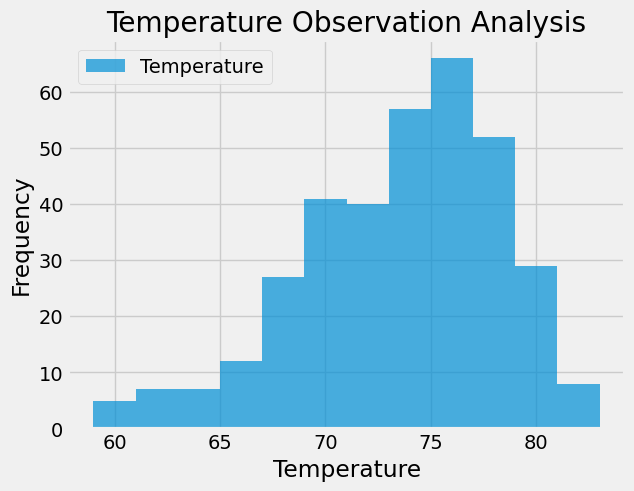

In [180]:
# Plot the results as a histogram
tobs_df.plot.hist(bins=12, alpha=0.7)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Temperature Observation Analysis")
plt.show()

In [181]:
# Close the session
session.close()

In [182]:
from flask import Flask, jsonify
import datetime as dt
from sqlalchemy import func

In [183]:
app = Flask(__name__)

# Define route to the homepage
@app.route("/")
def home():
    return (
        f"Welcome to Climate App!<br/><br/>"
        f"Available Routes:<br/>"
        f"<a href='/api/v1.0/precipitation'>/api/v1.0/precipitation</a><br/>"
        f"<a href='/api/v1.0/stations'>/api/v1.0/stations</a><br/>"
        f"<a href='/api/v1.0/tobs'>/api/v1.0/tobs</a><br/>"
        f"<a href='/api/v1.0/start_date'>/api/v1.0/start_date</a><br/>"
        f"<a href='/api/v1.0/start_date/end_date'>/api/v1.0/start_date/end_date</a>"
    )

In [184]:
# Define route to precipitation data
@app.route("/api/v1.0/precipitation")
def get_precipitation():
    # Calculate the date 1 year ago from the last data point in the database
    one_year_ago = dt.date.today() - dt.timedelta(days=365)
    # Query the last 12 months of precipitation data
    precipitation_data = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date >= one_year_ago).all()
    # Convert the query results to a dictionary
    precipitation_dict = {date: prcp for date, prcp in precipitation_data}
    return jsonify(precipitation_dict)

# Define route to list of stations
@app.route("/api/v1.0/stations")
def get_stations():
    # Query all stations
    stations = session.query(Station.station).all()
    # Convert the query results to a list
    station_list = [station[0] for station in stations]
    return jsonify(station_list)

# Define route to temperature observations for the most active station
@app.route("/api/v1.0/tobs")
def get_tobs():
    # Calculate the date 1 year ago from the last data point in the database
    one_year_ago = dt.date.today() - dt.timedelta(days=365)
    # Query the dates and temperature observations of the most active station for the previous year of data
    tobs_data = session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.station == most_active_station).\
        filter(Measurement.date >= one_year_ago).all()
    return jsonify(tobs_data)

# Define route to temperature statistics for specified start or start-end range
@app.route("/api/v1.0/<start_date>")
@app.route("/api/v1.0/<start_date>/<end_date>")
def get_temp_stats(start_date, end_date=None):
    # Define function to calculate temperature statistics
    def calc_temps(start, end):
        if not end:
            return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.date >= start).all()
        else:
            return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.date >= start).filter(Measurement.date <= end).all()

    # Call calc_temps function
    temperature_stats = calc_temps(start_date, end_date)
    # Convert the query results to a dictionary
    temp_stats_dict = {'TMIN': temperature_stats[0][0], 'TAVG': temperature_stats[0][1], 'TMAX': temperature_stats[0][2]}
    return jsonify(temp_stats_dict)

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

C:\Users\ipsit\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
